# Low-Level TensorFlow API

In this notebook you will learn how to use TensorFlow's low-level API, then use it to build custom loss functions, as well as custom Keras layers and models.

## Imports

In [74]:
%matplotlib inline

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [76]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.3 (default, Apr  3 2019, 05:39:12) 
[GCC 8.3.0]
matplotlib 3.1.0
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-dev20190623
tensorflow_core.keras 2.2.4-tf


In [77]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

## Tensors and operations

You can browse through the code examples or jump directly to the exercises.

### Tensors

In [78]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: id=339, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [79]:
t.shape

TensorShape([2, 3])

In [80]:
t.dtype

tf.float32

### Indexing

In [81]:
t[:, 1:]

<tf.Tensor: id=344, shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [82]:
t[..., 1, tf.newaxis]

<tf.Tensor: id=349, shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Ops

In [83]:
t + 10

<tf.Tensor: id=352, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [84]:
tf.square(t)

<tf.Tensor: id=354, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [85]:
t @ tf.transpose(t) 

<tf.Tensor: id=358, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### To/From NumPy

In [86]:
t.numpy() 

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [87]:
a = np.array([[1., 2., 3.], [4., 5., 6.]])
tf.constant(a)

<tf.Tensor: id=361, shape=(2, 3), dtype=float64, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]])>

In [88]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Scalars

In [89]:
t = tf.constant(2.718)
t

<tf.Tensor: id=364, shape=(), dtype=float32, numpy=2.718>

In [90]:
t.shape

TensorShape([])

In [91]:
t.numpy()

2.718

### Conflicting Types

In [92]:
try:
    tf.constant(1) + tf.constant(1.0)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute Add as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Add] name: add/


In [93]:
try:
    tf.constant(1.0, dtype=tf.float64) + tf.constant(1.0)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute Add as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Add] name: add/


In [94]:
t = tf.constant(1.0, dtype=tf.float64)
tf.cast(t, tf.float32) + tf.constant(1.0)

<tf.Tensor: id=374, shape=(), dtype=float32, numpy=2.0>

### Strings

In [95]:
t = tf.constant("café")
t

<tf.Tensor: id=376, shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [96]:
tf.strings.length(t)

<tf.Tensor: id=378, shape=(), dtype=int32, numpy=5>

In [97]:
tf.strings.length(t, unit="UTF8_CHAR")

<tf.Tensor: id=380, shape=(), dtype=int32, numpy=4>

In [98]:
tf.strings.unicode_decode(t, "UTF8")

<tf.Tensor: id=385, shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### String arrays

In [99]:
t = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [100]:
tf.strings.length(t, unit="UTF8_CHAR")

<tf.Tensor: id=388, shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [101]:
r = tf.strings.unicode_decode(t, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

### Ragged tensors

In [102]:
r = tf.ragged.constant([[11, 12], [21, 22, 23], [], [41]])
r

<tf.RaggedTensor [[11, 12], [21, 22, 23], [], [41]]>

In [103]:
print(r)

<tf.RaggedTensor [[11, 12], [21, 22, 23], [], [41]]>


In [104]:
print(r[1])

tf.Tensor([21 22 23], shape=(3,), dtype=int32)


In [105]:
print(r[1:2])

<tf.RaggedTensor [[21, 22, 23]]>


In [106]:
r2 = tf.ragged.constant([[51, 52], [], [71]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[11, 12], [21, 22, 23], [], [41], [51, 52], [], [71]]>


In [107]:
r3 = tf.ragged.constant([[13, 14, 15], [24], [], [42, 43]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[11, 12, 13, 14, 15], [21, 22, 23, 24], [], [41, 42, 43]]>


In [108]:
r.to_tensor()

<tf.Tensor: id=619, shape=(4, 3), dtype=int32, numpy=
array([[11, 12,  0],
       [21, 22, 23],
       [ 0,  0,  0],
       [41,  0,  0]], dtype=int32)>

### Sparse tensors

In [109]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [110]:
tf.sparse.to_dense(s)

<tf.Tensor: id=628, shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [111]:
s2 = s * 2.0

In [112]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [113]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: id=633, shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [114]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [115]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order [Op:SparseToDense]


In [116]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: id=648, shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Variables

In [117]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [118]:
v.value()

<tf.Tensor: id=660, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [119]:
v.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [120]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [121]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [122]:
v[1].assign([7., 8., 9.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 7.,  8.,  9.]], dtype=float32)>

In [123]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [124]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

In [125]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,   5.,   6.],
       [  1.,   2., 200.]], dtype=float32)>

### Devices

In [53]:
with tf.device("/cpu:0"):
    t = tf.constant([[1., 2., 3.], [4., 5., 6.]])

In [126]:
t.device

'/job:localhost/replica:0/task:0/device:CPU:0'

In [55]:
if tf.test.is_gpu_available():
    with tf.device("/gpu:0"):
        t2 = tf.constant([[1., 2., 3.], [4., 5., 6.]])
    print(t2.device)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [127]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 1.1)
Create an `my_mse()` function with two arguments: the true labels `y_true` and the model predictions `y_pred`. Make it return the mean squared error using TensorFlow operations. Note that you could write your own custom metrics in exactly the same way. **Tip**: recall that the MSE is the mean of the squares of prediction errors, which are the differences between the predictions and the labels, so you will need to use `tf.reduce_mean()` and `tf.square()`.

In [132]:
def my_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

### 1.2)
Compile the following model, passing it your custom loss function, then train it and evaluate it. **Tip**: don't forget to use the scaled sets.

In [139]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=my_mse)

history = model.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid),
          epochs = 100, 
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 33us/sample - loss: 2.0090 - val_loss: 0.7489
Epoch 2/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.6035 - val_loss: 0.5347
Epoch 3/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4862 - val_loss: 0.4771
Epoch 4/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4393 - val_loss: 0.3924
Epoch 5/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4141 - val_loss: 0.6198
Epoch 6/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4009 - val_loss: 0.3693
Epoch 7/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3917 - val_loss: 0.4321
Epoch 8/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3855 - val_loss: 0.3674
Epoch 9/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.379

### 1.3)
Try building and compiling the model again, this time adding `"mse"` (or equivalently `"mean_squared_error"` or `keras.losses.mean_squared_error`) to the list of additional metrics, then train the model and make sure the `my_mse` is equal to the standard `mse`.

In [138]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="mse")
history = model.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid),
          epochs = 100, 
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 39us/sample - loss: 1.8951 - val_loss: 0.9107
Epoch 2/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5979 - val_loss: 0.5217
Epoch 3/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4860 - val_loss: 0.4757
Epoch 4/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4388 - val_loss: 0.4460
Epoch 5/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4133 - val_loss: 0.3778
Epoch 6/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4043 - val_loss: 0.4112
Epoch 7/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3945 - val_loss: 0.3752
Epoch 8/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3927 - val_loss: 0.5582
Epoch 9/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.382

### 1.4)
If you want your code to be portable to other Python implementations of the Keras API, you should use the operations in `keras.backend` rather than TensorFlow operations directly. This package contains thin wrappers around the backend's operations (for example, `keras.backend.square()` simply calls `tf.square()`). Try reimplementing the `my_mse()` function this way and use it to train and evaluate your model again. **Tip**: people frequently define `K = keras.backend` to make their code more readable.

In [141]:
from tensorflow.keras import backend as K

def my_mse_keras(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))
    
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=my_mse_keras)
history = model.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid),
          epochs = 100, 
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 33us/sample - loss: 1.9328 - val_loss: 0.6994
Epoch 2/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5660 - val_loss: 0.5170
Epoch 3/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4645 - val_loss: 0.5235
Epoch 4/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4177 - val_loss: 0.7401
Epoch 5/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4004 - val_loss: 0.5230
Epoch 6/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3875 - val_loss: 0.7618
Epoch 7/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3829 - val_loss: 1.3310
Epoch 8/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3787 - val_loss: 0.8830
Epoch 9/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.371

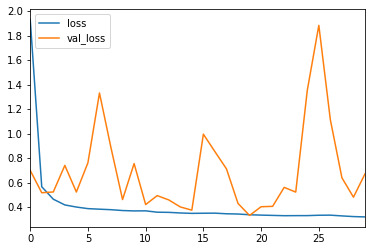

In [143]:
pd.DataFrame(history.history).plot()

In [144]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 12us/sample - loss: 0.3258


0.32576462975306103

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

### 1.1)
Create an `my_mse()` function with two arguments: the true labels `y_true` and the model predictions `y_pred`. Make it return the mean squared error using TensorFlow operations. Note that you could write your own custom metrics in exactly the same way. **Tip**: recall that the MSE is the mean of the squares of prediction errors, which are the differences between the predictions and the labels, so you will need to use `tf.reduce_mean()` and `tf.square()`.

In [58]:
def my_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

### 1.2)
Compile your model, passing it your custom loss function, then train it and evaluate it. **Tip**: don't forget to use the scaled sets.

In [59]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [60]:
model.compile(loss=my_mse, optimizer="sgd")

In [61]:
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 39us/sample - loss: 2.3013 - val_loss: 1.3952
Epoch 2/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.8092 - val_loss: 0.6777
Epoch 3/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6132 - val_loss: 0.5966
Epoch 4/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5610 - val_loss: 0.5658
Epoch 5/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5304 - val_loss: 0.5134
Epoch 6/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5088 - val_loss: 0.4962
Epoch 7/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4929 - val_loss: 0.5083
Epoch 8/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4804 - val_loss: 0.4826
Epoch 9/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4704 - val_l

In [62]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 14us/sample - loss: 0.4569


0.45686613663222436

### 1.3)
Try building and compiling the model again, this time adding `"mse"` (or equivalently `"mean_squared_error"` or `keras.losses.mean_squared_error`) to the list of additional metrics, then train the model and make sure the `my_mse` is equal to the standard `mse`.

In [63]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss=my_mse, optimizer="sgd", metrics=["mean_squared_error"])
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 41us/sample - loss: 2.6145 - mean_squared_error: 2.6145 - val_loss: 2.9651 - val_mean_squared_error: 2.9651
Epoch 2/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.8185 - mean_squared_error: 0.8185 - val_loss: 1.0717 - val_mean_squared_error: 1.0717
Epoch 3/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.7278 - mean_squared_error: 0.7278 - val_loss: 0.6705 - val_mean_squared_error: 0.6705
Epoch 4/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6809 - mean_squared_error: 0.6809 - val_loss: 0.7267 - val_mean_squared_error: 0.7267
Epoch 5/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.6535 - mean_squared_error: 0.6535 - val_loss: 0.6830 - val_mean_squared_error: 0.6830
Epoch 6/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6305 - mean_squared_err

[0.5441172193187152, 0.5441173]

### 1.4)
If you want your code to be portable to other Python implementations of the Keras API, you should use the operations in `keras.backend` rather than TensorFlow operations directly. This package contains thin wrappers around the backend's operations (for example, `keras.backend.square()` simply calls `tf.square()`). Try reimplementing the `my_mse()` function this way and use it to train and evaluate your model again. **Tip**: people frequently define `K = keras.backend` to make their code more readable.

In [64]:
def my_portable_mse(y_true, y_pred):
    K = keras.backend
    return K.mean(K.square(y_pred - y_true))

In [65]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss=my_portable_mse, optimizer="sgd", metrics=["mean_squared_error"])
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 42us/sample - loss: 1.9864 - mean_squared_error: 1.9864 - val_loss: 2.9839 - val_mean_squared_error: 2.9839
Epoch 2/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.7440 - mean_squared_error: 0.7440 - val_loss: 0.7090 - val_mean_squared_error: 0.7090
Epoch 3/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6614 - mean_squared_error: 0.6614 - val_loss: 0.6152 - val_mean_squared_error: 0.6152
Epoch 4/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6243 - mean_squared_error: 0.6243 - val_loss: 0.5762 - val_mean_squared_error: 0.5762
Epoch 5/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5936 - mean_squared_error: 0.5936 - val_loss: 0.5499 - val_mean_squared_error: 0.5499
Epoch 6/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5677 - mean_squared_err

[0.4914473322472831, 0.49144742]

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Custom layer

### 2.1)
Some layers have no weights, such as `keras.layers.Flatten` or `keras.layers.ReLU`. If you want to create a custom layer without any weights, the simplest option is to create a `keras.layers.Lambda` layer and pass it the function to perform. For example, try creating a custom layer that applies the softplus function (log(exp(X) + 1), and try calling this layer like a regular function.

**Tip**: you can use `tf.math.softplus()` rather than computing the log and the exponential manually.

In [145]:
mylayer = keras.layers.Lambda(function = tf.math.softplus)
# or mylayer = keras.layers.Lambda(lambda x: tf.math.softplus(x))

In [154]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
    keras.layers.Lambda(function = tf.math.softplus)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="mse")
history = model.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid),
          epochs = 100, 
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 35us/sample - loss: 1.2735 - val_loss: 1.8961
Epoch 2/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5262 - val_loss: 0.4270
Epoch 3/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4355 - val_loss: 0.3921
Epoch 4/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4087 - val_loss: 0.3728
Epoch 5/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3942 - val_loss: 0.3620
Epoch 6/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3859 - val_loss: 0.3594
Epoch 7/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3785 - val_loss: 0.3774
Epoch 8/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3742 - val_loss: 0.3553
Epoch 9/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.370

Epoch 76/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3038 - val_loss: 0.3101
Epoch 77/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3046 - val_loss: 0.4532
Epoch 78/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3071 - val_loss: 0.2933
Epoch 79/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3059 - val_loss: 0.2898


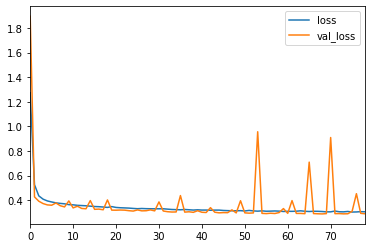

In [155]:
pd.DataFrame(history.history).plot()

### 2.2)
Create a regression model like in exercise 1, but add your softplus layer at the top (i.e., after the existing 1-unit dense layer). This can be useful to ensure that your model never predicts negative values.

In [156]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Lambda(function = tf.math.softplus),
    keras.layers.Dense(1),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="mse")
history = model.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid),
          epochs = 100, 
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 36us/sample - loss: 1.3435 - val_loss: 1.6577
Epoch 2/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4695 - val_loss: 0.7623
Epoch 3/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4137 - val_loss: 0.4525
Epoch 4/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3940 - val_loss: 0.4235
Epoch 5/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3841 - val_loss: 0.4194
Epoch 6/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3769 - val_loss: 0.4307
Epoch 7/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3711 - val_loss: 0.3836
Epoch 8/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3648 - val_loss: 0.5309
Epoch 9/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.361

Epoch 76/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2965 - val_loss: 0.2866
Epoch 77/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3013 - val_loss: 0.3356
Epoch 78/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2954 - val_loss: 0.2853
Epoch 79/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2952 - val_loss: 0.2865
Epoch 80/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2954 - val_loss: 0.4342
Epoch 81/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2958 - val_loss: 0.2855


### 2.3)
Alternatively, try using this softplus layer as the activation function of the output layer.

**Notes**:
* setting a layer's activation function is just a handy way of adding an extra weightless layer.
* Keras supports the softplus activation function out of the box:
  * set `activation="softplus"`
  * or set `activation=keras.activations.softplus`
  * or add a `keras.layers.Activation("softplus")` layer to your model.

In [157]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1, activation="softplus"),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="mse")
history = model.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid),
          epochs = 100, 
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 35us/sample - loss: 1.1410 - val_loss: 0.6002
Epoch 2/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5143 - val_loss: 0.4324
Epoch 3/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4300 - val_loss: 0.4575
Epoch 4/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4006 - val_loss: 0.3655
Epoch 5/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3874 - val_loss: 0.3940
Epoch 6/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3794 - val_loss: 0.4076
Epoch 7/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3772 - val_loss: 0.4717
Epoch 8/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3693 - val_loss: 0.4774
Epoch 9/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.366

Epoch 76/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.2971 - val_loss: 0.2898
Epoch 77/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.2969 - val_loss: 0.3681
Epoch 78/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.2976 - val_loss: 0.2912
Epoch 79/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.2992 - val_loss: 0.2882
Epoch 80/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2982 - val_loss: 0.3757
Epoch 81/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2956 - val_loss: 0.6016
Epoch 82/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2977 - val_loss: 0.2895
Epoch 83/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.2990 - val_loss: 0.2908


### 2.4)
Now let's create a custom layer with its own weights. Use the following template to create a `MyDense` layer that computes $\phi(\mathbf{X} \mathbf{W}) + \mathbf{b}$, where $\phi$ is the (optional) activation function, $\mathbf{X}$ is the input data, $\mathbf{W}$ represents the kernel (i.e., connection weights), and $\mathbf{b}$ represents the biases, then train and evaluate a model using this instead of a regular `Dense` layer.

**Tips**:
* The constructor `__init__()`:
  * It must have all your layer's hyperparameters as arguments, and save them to instance variables. You will need the number of `units` and the optional `activation` function. To support all kinds of activation functions (strings or functions), simply create a `keras.layers.Activation` passing it the `activation` argument.
  * The `**kwargs` argument must be passed to the base class's constructor (`super().__init__()`) so your class can support the `input_shape` argument, and more.
* The `build()` method:
  * The `build()` method will be called automatically by Keras when it knows the shape of the inputs. Note that the argument should really be called `batch_input_shape` since it includes the batch size.
  * You must call `self.add_weight()` for each weight you want to create, specifying its `name`, `shape` (which often depends on the `input_shape`), how to initialize it, and whether or not it is `trainable`. You need two weights: the `kernel` (connection weights) and the `biases`. The kernel must be initialized randomly. The biases are usually initialized with zeros. **Note**: you can find many initializers in `keras.initializers`.
  * Do not forget to call `super().build()`, so Keras knows that the model has been built.
  * Note: you could create the weights in the constructor, but it is preferable to create them in the `build()` method, because users of your class may not always know the `input_shape` when creating the model. The first time the model is used on some actual data, the `build()` method will automatically be called with the actual `input_shape`.
* The `call()` method:
  * This is where to code your layer's actual computations. As before, you can use TensorFlow operations directly, or use `keras.backend` operations if you want the layer to be portable to other Keras implementations.
* The `compute_output_shape()` method:
  * You do not need to implement this method when using tf.keras, as the `Layer` class provides a good implementation.
  * However, if want to port your code to another Keras implementation (such as keras-team), and if the output shape is different from the input shape, then you need to implement this method. Note that the input shape is actually the batch input shape, and the ouptut shape must be the batch output shape.

In [66]:
# This template was copied from https://keras.io/layers/writing-your-own-keras-layers/
# I just removed the imports and replaced Layer with keras.layers.Layer.

class MyLayer(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 – Solution

### 2.1)
Some layers have no weights, such as `keras.layers.Flatten` or `keras.layers.ReLU`. If you want to create a custom layer without any weights, the simplest option is to create a `keras.layers.Lambda` layer and pass it the function to perform. For example, try creating a custom layer that applies the softplus function (log(exp(X) + 1), and try calling this layer like a regular function.

In [67]:
my_softplus = keras.layers.Lambda(lambda X: tf.nn.softplus(X))

In [68]:
my_softplus([-10., -5., 0., 5., 10.])

<tf.Tensor: id=107512, shape=(5,), dtype=float32, numpy=
array([4.5417706e-05, 6.7153489e-03, 6.9314718e-01, 5.0067153e+00,
       1.0000046e+01], dtype=float32)>

### 2.2)
Create a regression model like in exercise 1, but add your softplus layer at the top (i.e., after the existing 1-unit dense layer). This can be useful to ensure that your model never predicts negative values.

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
    my_softplus
])
model.compile(loss=my_portable_mse, optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 38us/sample - loss: 2.1855 - val_loss: 1.6445
Epoch 2/10
11610/11610 [==============================] - 0s 32us/sample - loss: 1.0730 - val_loss: 0.8504
Epoch 3/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.8289 - val_loss: 0.7364
Epoch 4/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.7531 - val_loss: 0.6832
Epoch 5/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.7082 - val_loss: 0.6478
Epoch 6/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.6745 - val_loss: 0.6196
Epoch 7/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.6468 - val_loss: 0.5953
Epoch 8/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6221 - val_loss: 0.5733
Epoch 9/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5997 - val_l

0.564937449148459

### 2.3)
Alternatively, try using this softplus layer as the activation function of the output layer.

In [70]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1, activation=my_softplus)
#   A few alternatives...
#   keras.layers.Dense(1, activation=tf.function(lambda X: my_softplus(X)))
#   keras.layers.Dense(1, activation="softplus")
#   keras.layers.Dense(1, activation=keras.activations.softplus)
#   keras.layers.Dense(1), keras.layers.Activation("softplus")
])

model.compile(loss=my_portable_mse, optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 38us/sample - loss: 1.9194 - val_loss: 1.8773
Epoch 2/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.8180 - val_loss: 0.7519
Epoch 3/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.6807 - val_loss: 0.6417
Epoch 4/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6313 - val_loss: 0.6009
Epoch 5/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5954 - val_loss: 0.5693
Epoch 6/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5669 - val_loss: 0.5437
Epoch 7/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5440 - val_loss: 0.5220
Epoch 8/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5247 - val_loss: 0.5045
Epoch 9/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5087 - val_l

0.47681303236835687

### 2.4)
Now let's create a custom layer with its own weights. Use the following template to create a `MyDense` layer that computes $\phi(\mathbf{X} \mathbf{W}) + \mathbf{b}$, where $\phi$ is the (optional) activation function, $\mathbf{X}$ is the input data, $\mathbf{W}$ represents the kernel (i.e., connection weights), and $\mathbf{b}$ represents the biases, then train and evaluate a model using this instead of a regular `Dense` layer.

In [71]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(MyDense, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape is actually batch input shape
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super(MyDense, self).build(input_shape)

    def call(self, X):
        return self.activation(X @ self.kernel + self.biases)

In [72]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=X_train.shape[1:]),
    MyDense(1)
])

In [73]:
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 48us/sample - loss: 3.5886 - val_loss: 2.1575
Epoch 2/10
11610/11610 [==============================] - 0s 35us/sample - loss: 1.7396 - val_loss: 1.3169
Epoch 3/10
11610/11610 [==============================] - 0s 35us/sample - loss: 1.1695 - val_loss: 0.9721
Epoch 4/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.8931 - val_loss: 0.7806
Epoch 5/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.7530 - val_loss: 0.6845
Epoch 6/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6859 - val_loss: 0.6331
Epoch 7/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6483 - val_loss: 0.6010
Epoch 8/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6222 - val_loss: 0.5775
Epoch 9/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6013 - val_l

0.5634679314702056

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 3 – TensorFlow Functions

### 3.1)
Examine and run the following code examples.

In [158]:
def scaled_elu(z, scale=1.0, alpha=1.0):
    is_positive = tf.greater_equal(z, 0.0)
    return scale * tf.where(is_positive, z, alpha * tf.nn.elu(z))

In [159]:
scaled_elu(tf.constant(-3.))

<tf.Tensor: id=1032401, shape=(), dtype=float32, numpy=-0.95021296>

In [160]:
scaled_elu(tf.constant([-3., 2.5]))

<tf.Tensor: id=1032411, shape=(2,), dtype=float32, numpy=array([-0.95021296,  2.5       ], dtype=float32)>

In [161]:
scaled_elu_tf = tf.function(scaled_elu)
scaled_elu_tf

In [162]:
scaled_elu_tf(tf.constant(-3.))

<tf.Tensor: id=1032427, shape=(), dtype=float32, numpy=-0.95021296>

In [163]:
scaled_elu_tf(tf.constant([-3., 2.5]))

<tf.Tensor: id=1032442, shape=(2,), dtype=float32, numpy=array([-0.95021296,  2.5       ], dtype=float32)>

In [164]:
scaled_elu_tf.python_function is scaled_elu

True

In [165]:
%timeit scaled_elu(tf.random.normal((1000, 1000)))

7.61 ms ± 48.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [166]:
%timeit scaled_elu_tf(tf.random.normal((1000, 1000)))

6.73 ms ± 54.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [167]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func, experimental_optional_features=None)
    display(Markdown('```python\n{}\n```'.format(code)))

In [168]:
display_tf_code(scaled_elu)

```python
def tf__scaled_elu(z, scale=None, alpha=None):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  is_positive = ag__.converted_call('greater_equal', tf, ag__.STD, (z, 0.0), None)
  do_return = True
  retval_ = scale * ag__.converted_call('where', tf, ag__.STD, (is_positive, z, alpha * ag__.converted_call('elu', tf.nn, ag__.STD, (z,), None)), None)
  do_return,
  return ag__.retval(retval_)

```

In [169]:
var = tf.Variable(0)

@tf.function
def add_21():
    return var.assign_add(21)

@tf.function
def times_2():
    return var.assign(var * 2)

In [170]:
add_21()
times_2()

<tf.Tensor: id=1049511, shape=(), dtype=int32, numpy=42>

In [171]:
def times_4(x):
    return 4. * x

@tf.function
def times_4_plus_22(x):
    return times_4(x) + 22.

In [172]:
times_4_plus_22(tf.constant(5.))

<tf.Tensor: id=1049523, shape=(), dtype=float32, numpy=42.0>

Compute 1 + 1/2 + 1/4 + ...: the order of execution of the operations with side-effects (e.g., `assign()`) is preserved (in TF 1.x, `tf.control_dependencies()` was needed in such cases):

In [173]:
total = tf.Variable(0.)
increment = tf.Variable(1.)

@tf.function
def converge_to_2(n_iterations):
    for i in tf.range(n_iterations):
        total.assign_add(increment)
        increment.assign(increment / 2.0)
    return total

converge_to_2(20)

<tf.Tensor: id=1049606, shape=(), dtype=float32, numpy=1.9999981>

### 3.2)
Write a function that computes the sum of squares from 1 to n, where n is an argument. Convert it to a graph function by using `tf.function` as a decorator. Display the code generated by autograph using the `display_tf_code()` function. Use `%timeit` to see how must faster the TensorFlow `Function` is compared to the Python function.

### 3.3)
Examine and run the following code examples.

In [90]:
@tf.function
def square(x):
    tf.print("Calling", x)  # part of the TF Function
    print("Tracing")  # NOT part of the TF Function
    return tf.square(x)

In [91]:
for i in range(5):
    square(tf.constant(i))

Tracing
Calling 0
Calling 1
Calling 2
Calling 3
Calling 4


In [92]:
for i in range(5):
    square(tf.constant(i, dtype=tf.float32))

Tracing
Calling 0
Calling 1
Calling 2
Calling 3
Calling 4


In [93]:
for i in range(5):
    square(tf.constant([i, i], dtype=tf.float32))

Tracing
Calling [0 0]
Calling [1 1]
Calling [2 2]
Calling [3 3]
Calling [4 4]


In [94]:
# WARNING: when passing non-tensor values, a trace happens for any new value!
# This is to allow optimization in case this value determines e.g., number of layers.
for i in range(5):
    square(i)

Tracing
Calling 0
Tracing
Calling 1
Tracing
Calling 2
Tracing
Calling 3
Tracing
Calling 4


### 3.4)
When you give Keras a custom loss function, it actually creates a graph function based on it, and then uses that graph function during training. The same is true of custom metric functions, and the `call()` method of custom layers and models. Create a `my_mse()` function, like you did earlier, but add an instruction to log a message inside it (use `print()`, *not* `tf.print()`!), and verify that the message is only logged once when you compile and train the model. Optionally, you can also find out when Keras converts custom metrics, layers and models.

### 3.5)
Examine the following function, and try to call it with various argument types and shapes. Notice that only tensors of type `int32` and one dimension (of any size) are accepted now that we have specified the `input_signature`.

In [95]:
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name="x")])
def cube(z):
    return tf.pow(z, 3)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 3 – Solution

### 3.1)
Examine the code examples.

Done.

### 3.2)
Write a function that computes the sum of squares from 1 to n, where n is an argument. Convert it to a graph function by using `tf.function` as a decorator. Display the code generated by autograph using the `display_tf_code()` function. Use `%timeit` to see how must faster the TensorFlow `Function` is compared to the Python function.

In [96]:
@tf.function
def sum_squares(n):
    s = tf.constant(0)
    for i in range(1, n + 1):
        s = s + i ** 2
    return s

In [97]:
sum_squares(tf.constant(5))

<tf.Tensor: id=212810, shape=(), dtype=int32, numpy=55>

In [98]:
display_tf_code(sum_squares.python_function)

```python
from __future__ import print_function

def tf__sum_squares(n):
  do_return = False
  retval_ = None
  s = ag__.converted_call('constant', tf, ag__.ConversionOptions(recursive=True, verbose=0, strip_decorators=(ag__.convert, ag__.do_not_convert, ag__.converted_call), force_conversion=False, optional_features=(), internal_convert_user_code=True), (0,), {})

  def loop_body(loop_vars, s_1):
    i = loop_vars
    s_1 = s_1 + i ** 2
    return s_1,
  s, = ag__.for_stmt(ag__.converted_call(range, None, ag__.ConversionOptions(recursive=True, verbose=0, strip_decorators=(ag__.convert, ag__.do_not_convert, ag__.converted_call), force_conversion=False, optional_features=(), internal_convert_user_code=True), (1, n + 1), {}), None, loop_body, (s,))
  do_return = True
  retval_ = s
  return retval_



tf__sum_squares.autograph_info__ = {}

```

In [99]:
%timeit sum_squares(10000)

274 µs ± 90.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
%timeit sum_squares.python_function(10000)

358 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 3.3)
Examine the code examples.

Done.

### 3.4)
When you give Keras a custom loss function, it actually creates a graph function based on it, and then uses that graph function during training. The same is true of custom metric functions, and the `call()` method of custom layers and models. Create a `my_mse()` function, like you did earlier, but add an instruction to log a message inside it (use `print()`, *not* `tf.print()`!), and verify that the message is only logged once when you compile and train the model. Optionally, you can also find out when Keras converts custom metrics, layers and models.

In [101]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [102]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [103]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(MyDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super(MyDense, self).build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [104]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [105]:
model.compile(loss=my_mse, optimizer="sgd", metrics=[my_mae])

In [106]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing metric my_mae()
Tracing metric my_mae()
Tracing loss my_mse()
Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 46us/sample - loss: 3.3322 - my_mae: 1.4788 - val_loss: 1.9528 - val_my_mae: 0.9931
Epoch 2/2
5160/5160 [==============================] - 0s 15us/sample - loss: 0.8552 - my_mae: 0.6404


[0.8551779761794925, 0.640441]

Notice that each custom function is traced just once, except for the metric function. That's a bit odd.

### 3.5)
Examine the following function, and try to call it with various argument types and shapes. Notice that only tensors of type `int32` and one dimension (of any size) are accepted now that we have specified the `input_signature`.

In [107]:
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name="x")])
def cube(z):
    return tf.pow(z, 3)

In [108]:
cube(tf.constant([1, 2, 3]))

<tf.Tensor: id=401992, shape=(3,), dtype=int32, numpy=array([ 1,  8, 27], dtype=int32)>

In [109]:
cube(tf.constant([1, 2, 3, 4, 5]))

<tf.Tensor: id=401995, shape=(5,), dtype=int32, numpy=array([  1,   8,  27,  64, 125], dtype=int32)>

In [110]:
try:
    cube([1, 2, 3])
except ValueError as ex:
    print(ex)

In [111]:
try:
    cube(tf.constant([1., 2., 3]))
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature: inputs ((<tf.Tensor: id=401999, shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>,)), input_signature ((TensorSpec(shape=(None,), dtype=tf.int32, name='x'),))


In [112]:
try:
    cube(tf.constant([[1, 2], [3, 4]]))
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature: inputs ((<tf.Tensor: id=402001, shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>,)), input_signature ((TensorSpec(shape=(None,), dtype=tf.int32, name='x'),))


![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 4 – Function Graphs

### 4.1)
Examine and run the following code examples.

In [113]:
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name="x")])
def cube(z):
    return tf.pow(z, 3)

In [114]:
cube_func_int32 = cube.get_concrete_function(tf.TensorSpec([None], tf.int32))
cube_func_int32

In [115]:
cube_func_int32 is cube.get_concrete_function(tf.TensorSpec([5], tf.int32))

True

In [116]:
cube_func_int32 is cube.get_concrete_function(tf.constant([1, 2, 3]))

True

In [117]:
cube_func_int32.graph

### 4.2)
The function's graph is represented on the following diagram. Call the graph's `get_operations()` method to get the list of operations. Each operation has an `inputs` attribute that returns an iterator over its input tensors (these are symbolic: contrary to tensors we have used up to now, they have no value). It also has an `outputs` attribute that returns the list of output tensors. Each tensor has an `op` attribute that returns the operation it comes from. Try navigating through the graph using these methods and attributes.

<img src="images/cube_graph.png" width="600" />

### 4.3)
Each operation has a default name, such as `"pow"` (you can override it by setting the `name` attribute when you call the operation). In case of a name conflict, TensorFlow adds an underscore and anindex to make the name unique (e.g. `"pow_1"`). Moreover, each tensor has the same name as the operation that outputs it, followed by a colon `:` and the tensor's `index` (e.g., `"pow:0"`). Most operations have a single output tensor, so most tensors have a name that ends with `:0`. Try using `get_operation_by_name()` and `get_tensor_by_name()` to access any op and tensor you wish.

### 4.4)
Call the graph's `as_graph_def()` method and print the output. This is a protobuf representation of the computation graph: it is what makes TensorFlow models so portable.

### 4.5)
Get the concrete function's `function_def`, and look at its `signature`. This shows the names and types of the nodes in the graph that correspond to the function's inputs and outputs. This will come in handy when you deploy models to TensorFlow Serving or Google Cloud ML Engine.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 4 – Solution

### 4.1)
Examine the code examples.

Done.

### 4.2)
The function's graph is represented on the following diagram. Call the graph's `get_operations()` method to get the list of operations. Each operation has an `inputs` attribute that returns an iterator over its input tensors (these are symbolic: contrary to tensors we have used up to now, they have no value). It also has an `outputs` attribute that returns the list of output tensors. Each tensor has an `op` attribute that returns the operation it comes from. Try navigating through the graph using these methods and attributes.

<img src="images/cube_graph.png" width="600" />

In [118]:
cube_func_int32.graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Pow/y' type=Const>,
 <tf.Operation 'Pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [119]:
pow_op = cube_func_int32.graph.get_operations()[2]
pow_op

<tf.Operation 'Pow' type=Pow>

In [120]:
pow_in = list(pow_op.inputs)
pow_in

[<tf.Tensor 'x:0' shape=(None,) dtype=int32>,
 <tf.Tensor 'Pow/y:0' shape=() dtype=int32>]

In [121]:
pow_out = list(pow_op.outputs)
pow_out

[<tf.Tensor 'Pow:0' shape=(None,) dtype=int32>]

In [122]:
pow_in = list(pow_op.inputs)
pow_in

[<tf.Tensor 'x:0' shape=(None,) dtype=int32>,
 <tf.Tensor 'Pow/y:0' shape=() dtype=int32>]

In [123]:
pow_in[0].op

<tf.Operation 'x' type=Placeholder>

### 4.3)
Each operation has a default name, such as `"pow"` (you can override it by setting the `name` attribute when you call the operation). In case of a name conflict, TensorFlow adds an underscore and anindex to make the name unique (e.g. `"pow_1"`). Moreover, each tensor has the same name as the operation that outputs it, followed by a colon `:` and the tensor's `index` (e.g., `"pow:0"`). Most operations have a single output tensor, so most tensors have a name that ends with `:0`. Try using `get_operation_by_name()` and `get_tensor_by_name()` to access any op and tensor you wish.

In [124]:
cube_func_int32.graph.get_operation_by_name("x")

<tf.Operation 'x' type=Placeholder>

In [125]:
cube_func_int32.graph.get_tensor_by_name("x:0")

<tf.Tensor 'x:0' shape=(None,) dtype=int32>

### 4.4)
Call the graph's `as_graph_def()` method and print the output. This is a protobuf representation of the computation graph: it is what makes TensorFlow models so portable.

In [126]:
cube_func_int32.graph.as_graph_def()

node {
  name: "x"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "x"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
node {
  name: "Pow/y"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 3
      }
    }
  }
}
node {
  name: "Pow"
  op: "Pow"
  input: "x"
  input: "Pow/y"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
}
node {
  name: "Identity"
  op: "Identity"
  input: "Pow"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
}
versions {
  producer: 27
}

### 4.5)
Get the concrete function's `function_def`, and look at its `signature`. This shows the names and types of the nodes in the graph that correspond to the function's inputs and outputs. This will come in handy when you deploy models to TensorFlow Serving or Google Cloud ML Engine.

In [127]:
cube_func_int32.function_def.signature

name: "__inference_cube_402009"
input_arg {
  name: "x"
  type: DT_INT32
}
output_arg {
  name: "identity"
  type: DT_INT32
}

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 5 – Autodiff

### 5.1)
Examine and run the following code examples.

In [174]:
def f(x):
    return 3. * x ** 2 + 2. * x - 1.

In [175]:
def approximate_derivative(f, x, eps=1e-3):
    return (f(x + eps) - f(x - eps)) / (2. * eps)

In [176]:
approximate_derivative(f, 1.0) # true derivative = 8

7.999999999999119

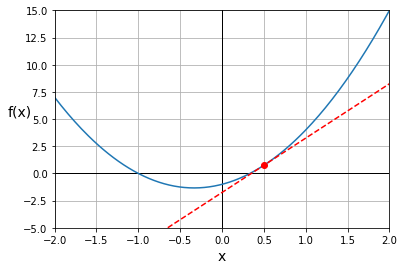

In [177]:
xs = np.linspace(-2, 2, 200)
fs = f(xs)
x0 = 0.5
df_x0 = approximate_derivative(f, x0)
tangent_x0 = df_x0 * (xs - x0) + f(x0)
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot([0, 0], [-5, 15], "k-", linewidth=1)
plt.plot(xs, fs)
plt.plot(xs, tangent_x0, "r--")
plt.plot(x0, f(x0), "ro")
plt.grid(True)
plt.xlabel("x", fontsize=14)
plt.ylabel("f(x)", fontsize=14, rotation=0)
plt.axis([-2, 2, -5, 15])
plt.show()

In [178]:
def g(x1, x2):
    return (x1 + 5) * (x2 ** 2)

In [179]:
def approximate_gradient(f, x1, x2, eps=1e-3):
    df_x1 = approximate_derivative(lambda x: f(x, x2), x1, eps)
    df_x2 = approximate_derivative(lambda x: f(x1, x), x2, eps)
    return df_x1, df_x2

In [180]:
approximate_gradient(g, 2.0, 3.0) # true gradient = (9, 42)

(8.999999999993236, 41.999999999994486)

In [181]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = g(x1, x2)
grads = tape.gradient(z, [x1, x2])
grads

[<tf.Tensor: id=1049630, shape=(), dtype=float32, numpy=9.0>,
 <tf.Tensor: id=1049642, shape=(), dtype=float32, numpy=42.0>]

In [182]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
try:
    dz_x2 = tape.gradient(z, x2)
except RuntimeError as ex:
    print(ex)

GradientTape.gradient can only be called once on non-persistent tapes.


In [183]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape(persistent=True) as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
dz_x2 = tape.gradient(z, x2)
del tape
dz_x1, dz_x2

(<tf.Tensor: id=1049728, shape=(), dtype=float32, numpy=9.0>,
 <tf.Tensor: id=1049767, shape=(), dtype=float32, numpy=42.0>)

In [184]:
x1 = tf.constant(2.0) # <= not Variable
x2 = tf.constant(3.0) # <= not Variable
with tf.GradientTape() as tape:
    z = g(x1, x2)

grads = tape.gradient(z, [x1, x2])
grads

[None, None]

In [139]:
x1 = tf.constant(2.0)
x2 = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x1)
    tape.watch(x2)
    z = g(x1, x2)

grads = tape.gradient(z, [x1, x2])
grads

[<tf.Tensor: id=402203, shape=(), dtype=float32, numpy=9.0>,
 <tf.Tensor: id=402215, shape=(), dtype=float32, numpy=42.0>]

In [140]:
x = tf.Variable(5.0)
with tf.GradientTape() as tape:
    z1 = 3 * x
    z2 = x ** 2
tape.gradient([z1, z2], x) # dz1_x + dz2_x = 3 + 2x = 3 + 2*5 = 13

<tf.Tensor: id=402272, shape=(), dtype=float32, numpy=13.0>

In [141]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = g(x1, x2)
    jacobians = jacobian_tape.gradient(z, [x1, x2])
hessians = [hessian_tape.gradient(jacobian, [x1, x2])
            for jacobian in jacobians]
del hessian_tape
hessians

[[None, <tf.Tensor: id=402335, shape=(), dtype=float32, numpy=6.0>],
 [<tf.Tensor: id=402389, shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: id=402372, shape=(), dtype=float32, numpy=14.0>]]

### 5.2)
Implement Gradient Descent manually to find the value of `x` that minimizes the following function `f(x)`.

**Tips**:
* Define a variable `x` and initialize it to 0.
* Define the `learning_rate` (e.g., 0.1).
* Write a loop that will repeatedly (1) compute the gradient of `f` (actually a derivative in this case) at the current value of `x`, and (2) tweak `x` slightly in the opposite direction (by subtracting `learning_rate * df_dx`). You can use `x.assign_sub(...)` for this.
* Using calculus, we can find that the algorithm should converge to $x = -\frac{1}{3}$. Indeed, the derivative of $f(x) = 3 x^2 + 2x -1$ is $f'(x) = 6x + 2$, so the minimum is reached when $f'(x) = 0$ (slope is 0), so $6x + 2 = 0$, which leads to $x = -\frac{1}{3}$.


In [142]:
def f(x):
    return 3. * x ** 2 + 2. * x - 1.

### 5.3)
Now use an `SGD` optimizer instead of manually tweaking `x`.

**Tips**:
* You first need to create an `SGD` optimizer, optionally specifying the learning_rate (e.g., `lr=0.1`).
* Next replace the manual tweaking of `x` in your previous code to use `optimizer.apply_gradients()` instead. You need to pass it a list of gradient/variable pairs (just one pair in this example).

### 5.4)
Create a `Sequential` model for the California housing problem (no need to compile it), and train it using your own training loop, instead of using `fit()`. Evaluate your model on the validation set at the end of each epoch, and display the result.

**Tips**:
* You can use the following `random_batch()` function to get a new batch of training data at each iteration (the Data API would be much preferable, as we will see in the next notebook).
* You can use the model like a function to make predictions: `y_pred = model(X_batch)`
* You can use `keras.losses.mean_squared_error()` to compute the loss. Note that it returns one loss per instance, so you need to use `tf.reduce_mean()` to get the mean loss. 
* You can use `model.trainable_variables` to get the full list of trainable variables in your model.
* You can use `zip(gradients, variables)` to create a list containing all the gradient/variable pairs.

In [143]:
def random_batch(X, y, batch_size = 32):
    idx = np.random.randint(0, len(X), size=batch_size)
    return X[idx], y[idx]

### 5.5)
Examine and run the following code examples, then update your training loop to display the training loss at each iteration.

**Tips**:
* You can use a `keras.metrics.MeanSquaredError` instance to efficiently track the running mean squared error at each iteration.
* Make sure you reset the metric's states at the start of each epoch.
* You can use `print("\r", mse, end="")` to display the MSE on the same line at each iteration.

In [144]:
metric = keras.metrics.MeanSquaredError()
metric([5.], [2.])  # error = (2 - 5)**2 = 9
metric([0.], [1.])  # error = (1 - 0)**2 = 1
metric.result()     # mean error = (9 + 1) / 2 = 5

<tf.Tensor: id=402433, shape=(), dtype=float32, numpy=5.0>

In [145]:
metric.reset_states()
metric.result()

<tf.Tensor: id=402439, shape=(), dtype=float32, numpy=0.0>

In [146]:
metric([1.], [3.])  # error = (3 - 1)**2 = 4
metric.result()     # mean error = 4 / 1 = 4

<tf.Tensor: id=402455, shape=(), dtype=float32, numpy=4.0>

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 5 – Solution

### 5.1)
Examine the code examples.

Done

### 5.2)
Implement Gradient Descent manually to find the value of `x` that minimizes the following function `f(x)`.

In [147]:
def f(x):
    return 3. * x ** 2 + 2. * x - 1.

In [148]:
learning_rate = 0.1
x = tf.Variable(0.0)

for iteration in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z, x)
    x.assign_sub(learning_rate * dz_dx)
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3333333>

### 5.3)
Now use an `SGD` optimizer instead of manually tweaking `x`.

In [149]:
x = tf.Variable(0.0)
optimizer = keras.optimizers.SGD(lr=0.1)

for iteration in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z, x)
    optimizer.apply_gradients([(dz_dx, x)])
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3333333>

### 5.4)
Create a `Sequential` model for the California housing problem (no need to compile it), and train it using your own training loop, instead of using `fit()`. Evaluate your model on the validation set at the end of each epoch, and display the result.

In [150]:
def random_batch(X, y, batch_size = 32):
    idx = np.random.randint(0, len(X), size=batch_size)
    return X[idx], y[idx]

In [151]:
epochs = 10
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
optimizer = keras.optimizers.SGD()
loss_fn = keras.losses.mean_squared_error

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        X_batch, y_batch = random_batch(X_train_scaled, y_train, batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        grads = tape.gradient(loss, model.variables)
        grads_and_vars = zip(grads, model.variables)
        optimizer.apply_gradients(grads_and_vars)
    y_pred = model(X_valid_scaled)
    valid_loss = tf.reduce_mean(loss_fn(y_valid, y_pred))
    print("Epoch", epoch, "valid mse:", valid_loss.numpy())

Epoch 0 valid mse: 4.567194
Epoch 1 valid mse: 1.0170918
Epoch 2 valid mse: 1.7955109
Epoch 3 valid mse: 0.596315
Epoch 4 valid mse: 0.58101755
Epoch 5 valid mse: 0.53072745
Epoch 6 valid mse: 0.66618234
Epoch 7 valid mse: 1.0245769
Epoch 8 valid mse: 0.4872077
Epoch 9 valid mse: 0.53296995


### 5.5)
Examine and run the following code examples, then update your training loop to display the training loss at each iteration.

In [152]:
metric = keras.metrics.MeanSquaredError()
metric([5.], [2.])  # error = (2 - 5)**2 = 9
metric([0.], [1.])  # error = (1 - 0)**2 = 1
metric.result()     # mean error = (9 + 1) / 2 = 5

<tf.Tensor: id=639680, shape=(), dtype=float32, numpy=5.0>

In [153]:
metric.reset_states()
metric.result()

<tf.Tensor: id=639686, shape=(), dtype=float32, numpy=0.0>

In [154]:
metric([1.], [3.])  # error = (3 - 1)**2 = 4
metric.result()     # mean error = 4 / 1 = 4

<tf.Tensor: id=639702, shape=(), dtype=float32, numpy=4.0>

In [155]:
epochs = 10
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
optimizer = keras.optimizers.SGD()
loss_fn = keras.losses.mean_squared_error
metric = keras.metrics.MeanSquaredError()  # ADDED

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

for epoch in range(epochs):
    metric.reset_states()  # ADDED
    for step in range(steps_per_epoch):
        X_batch, y_batch = random_batch(X_train_scaled, y_train, batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            metric(y_batch, y_pred)  # ADDED
        grads = tape.gradient(loss, model.trainable_variables)
        grads_and_vars = zip(grads, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars)
        print("\rEpoch", epoch, " train mse:", metric.result().numpy(), end="")  # ADDED
    y_pred = model(X_valid_scaled)
    valid_loss = tf.reduce_mean(loss_fn(y_valid, y_pred))
    print("\tvalid mse:", valid_loss.numpy())

Epoch 0  train mse: 2.7752223	valid mse: 5.3992133
Epoch 1  train mse: 0.90346783	valid mse: 0.85499036
Epoch 2  train mse: 0.73343664	valid mse: 0.65248495
Epoch 3  train mse: 0.6572704	valid mse: 0.73229337
Epoch 4  train mse: 0.6271633	valid mse: 0.89375675
Epoch 5  train mse: 0.5680934	valid mse: 0.62792087
Epoch 6  train mse: 0.5731681	valid mse: 0.548600125
Epoch 7  train mse: 0.5597209	valid mse: 0.51854014
Epoch 8  train mse: 0.52296084	valid mse: 0.5335406
Epoch 9  train mse: 0.5074372	valid mse: 0.5076812


## Conclusion

Great! You now know how to use TensorFlow's low-level API to write custom loss functions, layers, and models. You also learned how to optimize your functions by converting them to graphs: this allows TensorFlow to run operations in parallel and to perform various optimizations. Next, you learned how TensorFlow Functions and graphs are structured, and how to navigate through them. Finally, you learned how to use autodiff and write your own custom training loops.